# Prophet training
- This is an auto-generated notebook.
- To reproduce these results, attach this notebook to a cluster with runtime version **15.4.x-cpu-ml-scala2.12**, and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/2548317818372766).
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

In [0]:
dbutils.widgets.text("catalog", "stuart", "Default UC catalog")
dbutils.widgets.text("schema", "ts", "Default UC schema")
dbutils.widgets.text("ts_freq", "months", "Data frequency to use for forecast")

In [0]:
CATALOG = dbutils.widgets.get("catalog")
SCHEMA = dbutils.widgets.get("schema")

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "value"
time_col = "ts"
unit = dbutils.widgets.get("ts_freq")

id_cols = ["cdid"]

horizon = 12

## Load Data

In [0]:
import mlflow
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Create temp directory to download input data from MLflow
# input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
# os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
# input_data_path = mlflow.artifacts.download_artifacts(run_id="8ea83719a4a14a1fa7b8ff3804276760", artifact_path="data", dst_path=input_temp_dir)

# input_file_path = os.path.join(input_data_path, "training_data")
# input_file_path = "file://" + input_file_path
# df_loaded = ps.from_pandas(pd.read_parquet(input_file_path))

df_loaded = spark.table(f"{CATALOG}.{SCHEMA}.gold_{unit}").to_pandas_on_spark()

# Preview data
display(df_loaded.head(5))

/databricks/spark/python/pyspark/sql/dataframe.py:6934: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


cdid,publishedPeriod,releaseDate,label,month,quarter,sourceDataset,updateDate,value,year,ts
D7BT,2024 JUN,2024-07-16T23:00:00.000Z,1988 JAN,January,,MM23,2016-01-19T09:30:00Z,48.4,1988,1988-01-01T00:00:00Z
D7BT,2024 JUN,2024-07-16T23:00:00.000Z,1988 FEB,February,,MM23,2018-12-19T00:00:00Z,48.6,1988,1988-02-01T00:00:00Z
D7BT,2024 JUN,2024-07-16T23:00:00.000Z,1988 MAR,March,,MM23,2016-01-19T09:30:00Z,48.7,1988,1988-03-01T00:00:00Z
D7BT,2024 JUN,2024-07-16T23:00:00.000Z,1988 APR,April,,MM23,2016-01-19T09:30:00Z,49.3,1988,1988-04-01T00:00:00Z
D7BT,2024 JUN,2024-07-16T23:00:00.000Z,1988 MAY,May,,MM23,2016-01-19T09:30:00Z,49.5,1988,1988-05-01T00:00:00Z


## Aggregate data by `id_col` and `time_col`
Group the data by `id_col` and `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col] + id_cols

df_aggregated = df_loaded \
  .groupby(group_cols) \
  .agg(y=(target_col, "avg")) \
  .reset_index()

df_aggregated = df_aggregated.assign(ts_id=lambda x:x["cdid"].astype(str))


display(df_aggregated.head(5))

ts,cdid,y,ts_id
2004-02-01T00:00:00Z,DK9J,103.3,DK9J
1995-01-01T00:00:00Z,D7BU,62.4,D7BU
2009-03-01T00:00:00Z,D7F5,81.7,D7F5
2010-07-01T00:00:00Z,D7F5,86.1,D7F5
2018-11-01T00:00:00Z,D7F5,108.5,D7F5


## Train Prophet model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2548317818372766)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

In [0]:
import logging

# disable informational messages from prophet
logging.getLogger("py4j").setLevel(logging.WARNING)

In [0]:
from pyspark.sql.types import *

df_schema = df_aggregated.to_spark().schema
result_columns = id_cols + ["model_json", "prophet_params", "start_time", "end_time", "mse",
                  "rmse", "mae", "mape", "mdape", "smape", "coverage"]
result_schema = StructType(
  [StructField(id_col, df_schema[id_col].dataType) for id_col in id_cols] + [
  StructField("model_json", StringType()),
  StructField("prophet_params", StringType()),
  StructField("start_time", TimestampType()),
  StructField("end_time", TimestampType()),
  StructField("mse", FloatType()),
  StructField("rmse", FloatType()),
  StructField("mae", FloatType()),
  StructField("mape", FloatType()),
  StructField("mdape", FloatType()),
  StructField("smape", FloatType()),
  StructField("coverage", FloatType())
  ])

def prophet_training(history_pd):
  from hyperopt import hp
  from databricks.automl_runtime.forecast.prophet.forecast import ProphetHyperoptEstimator

  seasonality_mode = ["additive", "multiplicative"]
  search_space =  {
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, 3.0),
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),
    "holidays_prior_scale": hp.loguniform("holidays_prior_scale", -6.9, 2.3),
    "seasonality_mode": hp.choice("seasonality_mode", seasonality_mode)
  }
  country_holidays = None
  run_parallel = False
 
  hyperopt_estim = ProphetHyperoptEstimator(horizon=horizon, frequency_unit=unit, metric="smape",interval_width=0.95,
                   country_holidays=country_holidays, search_space=search_space, num_folds=5, max_eval=10, trial_timeout=7092,
                   random_state=310277476, is_parallel=run_parallel)

  results_pd = hyperopt_estim.fit(history_pd)
  results_pd[id_cols] = history_pd[id_cols]
  results_pd["start_time"] = pd.Timestamp(history_pd["ds"].min())
  results_pd["end_time"] = pd.Timestamp(history_pd["ds"].max())
 
  return results_pd[result_columns]

def train_with_fail_safe(df):
  try:
    return prophet_training(df)
  except Exception as e:
    print(f"Encountered an exception while training timeseries: {repr(e)}")
    return pd.DataFrame(columns=result_columns)

In [0]:
import mlflow
from databricks.automl_runtime.forecast.prophet.model import mlflow_prophet_log_model, MultiSeriesProphetModel

with mlflow.start_run() as mlflow_run:
  mlflow.set_tag("estimator_name", "Prophet")
  mlflow.log_param("interval_width", 0.95)
  df_aggregated = df_aggregated.rename(columns={time_col: "ds"})

  forecast_results = (df_aggregated.to_spark().repartition(sc.defaultParallelism, "ts_id") \
    .groupby("ts_id").applyInPandas(train_with_fail_safe, result_schema)).cache().pandas_api()
  results_pdf = forecast_results[id_cols + ["model_json", "start_time", "end_time"]].to_pandas()
  results_pdf["ts_id"] = results_pdf[id_cols].astype(str).agg('-'.join, axis=1)
  results_pdf["ts_id_tuple"] = results_pdf[id_cols].apply(tuple, axis=1)
   
  # Check whether every time series's model is trained
  ts_models_trained = set(results_pdf["ts_id"].unique().tolist())
  ts_ids = set(df_aggregated["ts_id"].unique().tolist())

  if len(ts_models_trained) == 0:
    raise Exception("Trial unable to train models for any identities. Please check the training cell for error details")

  if ts_ids != ts_models_trained:
    mlflow.log_param("partial_model", True)
    print(f"WARNING: Models not trained for the following identities: {ts_ids.difference(ts_models_trained)}")
 
  # Log the metrics to mlflow
  metric_name_map = {"mse": "mean_squared_error", "rmse": "root_mean_squared_error", "mae": "mean_absolute_error",
                     "mape": "mean_absolute_percentage_error", "mdape": "mdape", "smape": "smape", "coverage": "coverage"}
  avg_metrics = forecast_results[metric_name_map.keys()].rename(columns=metric_name_map).mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Create mlflow prophet model
  results_pdf = results_pdf.set_index("ts_id_tuple")
  model_json = results_pdf["model_json"].to_dict()
  start_time = results_pdf["start_time"].to_dict()
  end_time = results_pdf["end_time"].to_dict()
  end_history_time = max(end_time.values())
  prophet_model = MultiSeriesProphetModel(model_json, start_time, end_history_time, horizon, unit, time_col, id_cols)

  # Generate sample input dataframe
  sample_input = df_loaded.head(1).to_pandas()
  sample_input[time_col] = pd.to_datetime(sample_input[time_col])
  sample_input.drop(columns=[target_col], inplace=True)

  mlflow_prophet_log_model(prophet_model, sample_input=sample_input)

/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
/databricks/python/lib/python3.11/site-packages/databricks/automl_runtime/forecast/prophet/model.py:301: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  predict_df = test_df.grou

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
# Show stats of forecast_results. By default we do not display it because the output takes up a lot of storage for large datasets.
# Change this line to `forecast_results.head()` and re-run the notebook to check the result.
forecast_results.describe()

,start_time,end_time,mse,rmse,mae,mape,mdape,smape,coverage
count,5,5,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1988-01-01 00:00:00,2024-06-01 00:00:00,91.095406,8.786637,7.973725,0.063437,0.069264,0.066355,0.107197
min,1988-01-01 00:00:00,2024-06-01 00:00:00,36.055672,5.880696,5.022129,0.038949,0.042049,0.040040,0.000000
25%,1988-01-01 00:00:00,2024-06-01 00:00:00,38.890091,6.150125,5.891718,0.047739,0.050021,0.049032,0.000000
50%,1988-01-01 00:00:00,2024-06-01 00:00:00,53.517326,7.260251,7.040314,0.060057,0.061988,0.062060,0.000000
75%,1988-01-01 00:00:00,2024-06-01 00:00:00,88.119255,9.290208,8.853139,0.069654,0.073850,0.072464,0.193182
max,1988-01-01 00:00:00,2024-06-01 00:00:00,238.894669,15.351906,13.061327,0.100787,0.118413,0.108179,0.342803
std,None,None,85.176814,3.907745,3.184925,0.023933,0.030002,0.026446,0.156027


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

In [0]:
model = loaded_model._model_impl.python_model
col_types = [StructField(f"{n}", FloatType()) for n in model.get_reserved_cols()]
col_types.append(StructField("ds",TimestampType()))
col_types.append(StructField("ts_id",StringType()))
result_schema = StructType(col_types)

future_df = model.make_future_dataframe(include_history=False)
future_df["ts_id"] = future_df[id_cols].apply(tuple, axis=1)
future_df = future_df.rename(columns={time_col: "ds"})
display(future_df.head(5))

ds,cdid,ts_id
2024-07-01T00:00:00Z,DKC6,List(DKC6)
2024-08-01T00:00:00Z,DKC6,List(DKC6)
2024-09-01T00:00:00Z,DKC6,List(DKC6)
2024-10-01T00:00:00Z,DKC6,List(DKC6)
2024-11-01T00:00:00Z,DKC6,List(DKC6)


In [0]:
# Predict future with the default horizon
forecast_pd = future_df.groupby(id_cols).apply(lambda df: model._predict_impl(df, model._horizon)).reset_index(drop=True)

/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
/databricks/python/lib/python3.11/site-packages/prophet/

In [0]:
# Plotly plots is turned off by default because it takes up a lot of storage.
# Set this flag to True and re-run the notebook to see the interactive plots with plotly
use_plotly = False

In [0]:
# Choose a random id for plot
forecast_pd["ts_id"] = forecast_pd[id_cols].apply(tuple, axis=1)
id = set(forecast_pd.index.to_list()).pop()
ts_id = forecast_pd["ts_id"].loc[id]
# Get the prophet model for plot
model = loaded_model._model_impl.python_model.model(ts_id)
predict_pd = forecast_pd[forecast_pd["ts_id"] == ts_id]

/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


### Plot the forecast with change points and trend
Plot the forecast using the `plot` method with your forecast dataframe. You can use `prophet.plot.add_changepoints_to_plot` to overlay significant changepoints. An interactive figure can be created with plotly.

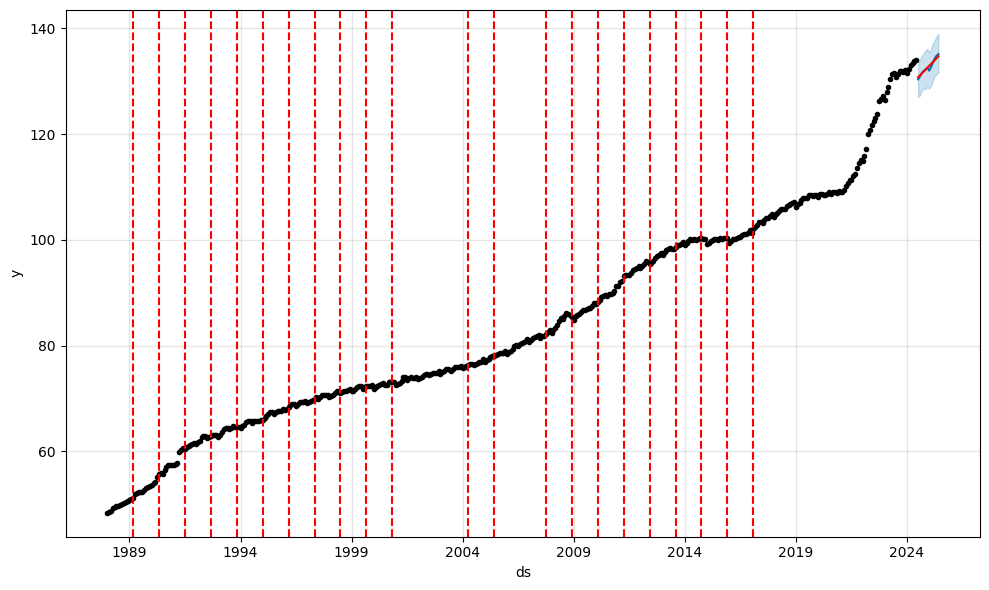

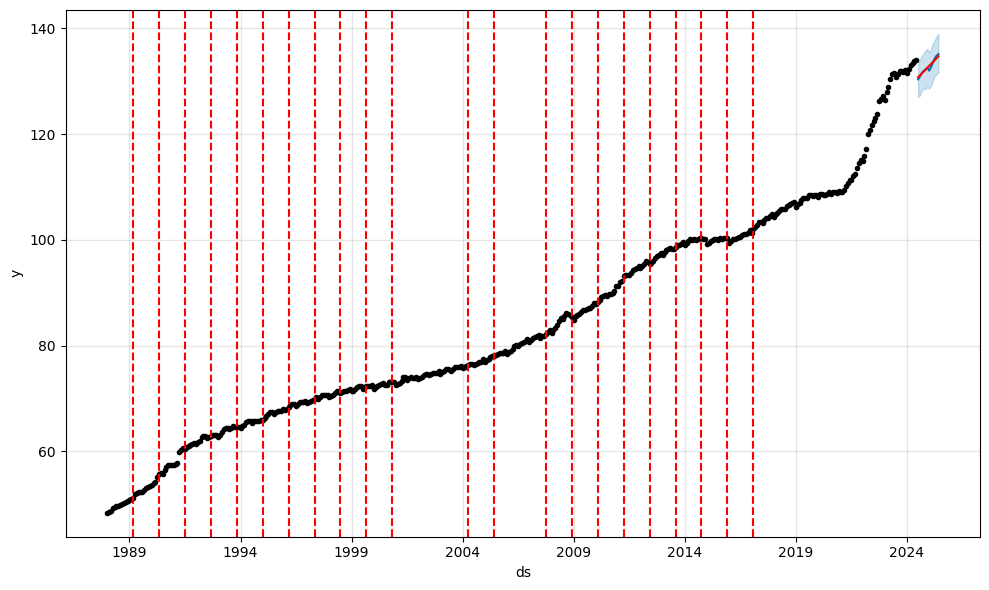

In [0]:
from prophet.plot import add_changepoints_to_plot, plot_plotly

if use_plotly:
    fig = plot_plotly(model, predict_pd, changepoints=True, trend=True, figsize=(1200, 600))
else:
    fig = model.plot(predict_pd)
    a = add_changepoints_to_plot(fig.gca(), model, predict_pd)
fig

### Plot the forecast components
Use the `Prophet.plot_components` method to see the components. By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series. You can also include holidays. An interactive figure can be created with plotly.

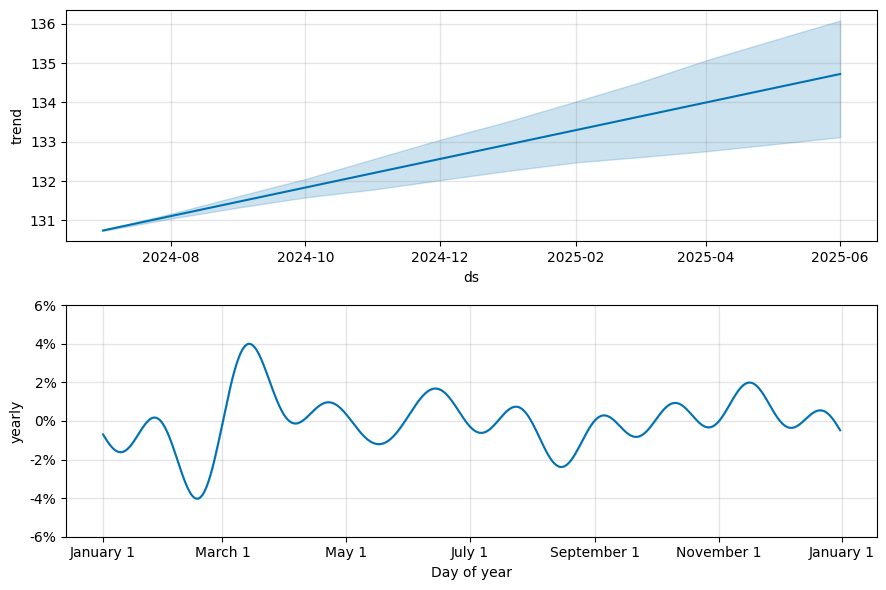

In [0]:
from prophet.plot import plot_components_plotly
if use_plotly:
    fig = plot_components_plotly(model, predict_pd, figsize=(900, 400))
    fig.show()
else:
    fig = model.plot_components(predict_pd)

## Show the predicted results

In [0]:
predict_cols = id_cols + ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].tail(horizon))

cdid,ds,yhat
DKC6,2024-07-01T00:00:00Z,126.39936587429219
DKC6,2024-08-01T00:00:00Z,126.93409025825241
DKC6,2024-09-01T00:00:00Z,127.39631626061073
DKC6,2024-10-01T00:00:00Z,127.73956587887304
DKC6,2024-11-01T00:00:00Z,128.00504301301658
DKC6,2024-12-01T00:00:00Z,128.44973065649813
DKC6,2025-01-01T00:00:00Z,127.86631585160627
DKC6,2025-02-01T00:00:00Z,128.4551628695712
DKC6,2025-03-01T00:00:00Z,128.96051407714933
DKC6,2025-04-01T00:00:00Z,129.58227499977676


In [0]:
(
  spark.createDataFrame(forecast_pd)
  .write
  .mode("overwrite")
  .saveAsTable(f"{CATALOG}.{SCHEMA}.gold_predictions")
  )